## Basic noise covariance operators (and their inverse) 

This notebook shows how to create the basic noise covariance operators and their inverse. While creating the noise operators, we assume that the noise is stationary in time. All (inverse) noise covariance operators offer an attribute `diag` that can be used to retrieve the diagonal of the operator, and a method `get_inverse()` that simply returns the inverse of the operator.

All noise covariance operators and their inverses are defined locally. This means that, for consistency, the user must ensure that the noise covariance and its inverse defined on each MPI process correspond to the Time-Ordered Data (TOD) available locally on that process.

Unless otherwise mentioned explicitly, all (inverse) noise covariance operators can be defined using following arguments:

- `size`  
    The dimension of the operator
- `input`  
    The input array containing the noise property in terms of noise covariance or power spectrum
- `input_type`  
    The name of the noise property. If `input` argument contains the noise covariance, `input_type` must be `"covariance"`. Likewise, if the `input` argument contains the power spectrum array, the `input_type` must be `power_spectrum`.
- `dtype`  
    The data-type of the operator


<div class="alert alert-block alert-warning">

**NOTE**  
The linear operators defined in BrahMap can be visualized using the `brahmap.utilities.plot_LinearOperator()` function. This function requires `matplotlib` to be installed. However, it must be used very carefully, as it allocates a large array in memory - matching the dimensions of the linear operator - which can quickly crash your system. In these examples, we use this function because our operators are very small.

</div>


In [1]:
import brahmap
from brahmap.utilities import plot_LinearOperator
import numpy as np

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


### Diagonal noise covariance

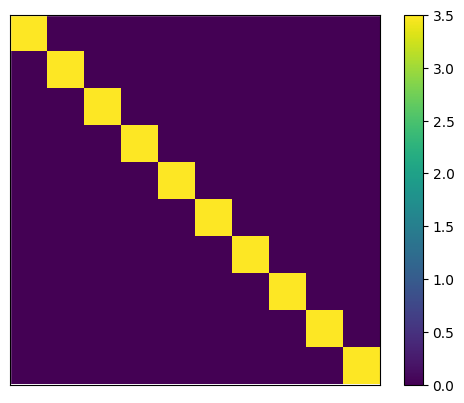

In [2]:
### Diagonal noise covariance operator with noise variance 3.5

diag_noise_cov = brahmap.NoiseCovLO_Diagonal(
    size=10,
    input=3.5,  # White noise variance
    input_type="covariance",
    dtype=np.float32,
)

### Visualizing the operator
plot_LinearOperator(diag_noise_cov)

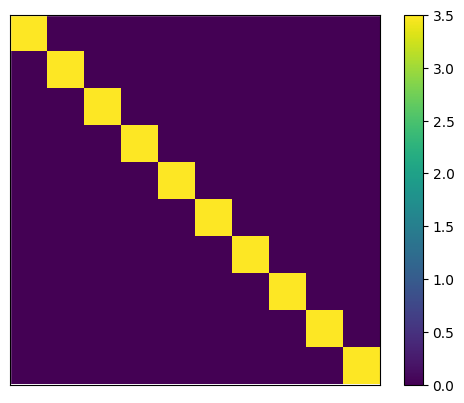

In [3]:
### Inverse of diagonal noise covariance operator with noise variance 3.5

inv_diag_noise_cov = brahmap.InvNoiseCovLO_Diagonal(
    size=10,
    input=3.5,  # White noise variance
    input_type="covariance",
    dtype=np.float32,
)

### Visualizing the operator
plot_LinearOperator(diag_noise_cov)

In [4]:
### We can verify that the product of the two operators is an identity

mat_prod_diag = (diag_noise_cov * inv_diag_noise_cov).to_array()
print(mat_prod_diag)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### Circulant noise covariance

In [5]:
### Defining circulant covariance array and power spectrum

# Size of the covariance operator
size_circ = 10

# Generate a simple 1/f spectrum
freqs_circ = np.fft.fftfreq(size_circ)
power_spec_circ = np.zeros(size_circ)
power_spec_circ[1:] = 1.0 / np.abs(freqs_circ[1:])
power_spec_circ[0] = 50

# Compute the self covariance from power spectrum
noise_cov_circ = np.fft.ifft(power_spec_circ).real

In [6]:
### Defining circulant noise covariance operator with self covariance as input
circulant_noise_cov1 = brahmap.NoiseCovLO_Circulant(
    size=size_circ,
    input=noise_cov_circ,
    input_type="covariance",
    dtype=np.float32,
)


### Defining circulant noise covariance operator with power spectrum as input
circulant_noise_cov2 = brahmap.NoiseCovLO_Circulant(
    size=size_circ,
    input=power_spec_circ,
    input_type="power_spectrum",
    dtype=np.float32,
)

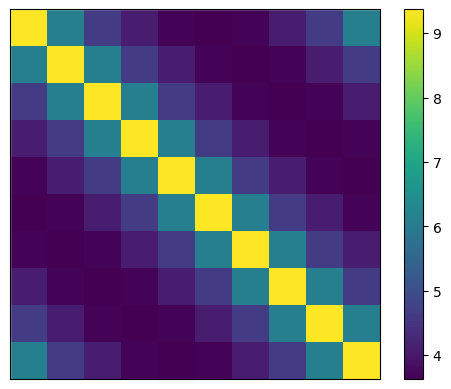

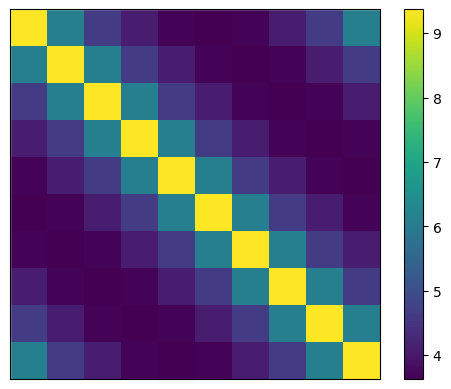

In [7]:
### Visualizing the two covariance operators
plot_LinearOperator(circulant_noise_cov1)
plot_LinearOperator(circulant_noise_cov2)

In [8]:
### We can verify that the two operators defined above are equal

np.testing.assert_allclose(
    circulant_noise_cov2.to_array(),
    circulant_noise_cov1.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [9]:
### Defining inverse circulant noise covariance operator with self covariance as input
inv_circulant_noise_cov1 = brahmap.InvNoiseCovLO_Circulant(
    size=size_circ,
    input=noise_cov_circ,
    input_type="covariance",
    dtype=np.float32,
)


### Defining inverse circulant noise covariance operator with power spectrum as input
inv_circulant_noise_cov2 = brahmap.InvNoiseCovLO_Circulant(
    size=size_circ,
    input=power_spec_circ,
    input_type="power_spectrum",
    dtype=np.float32,
)

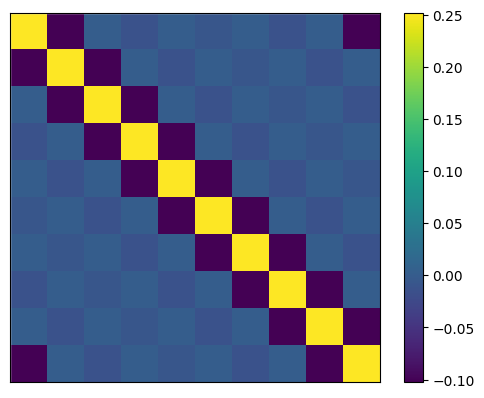

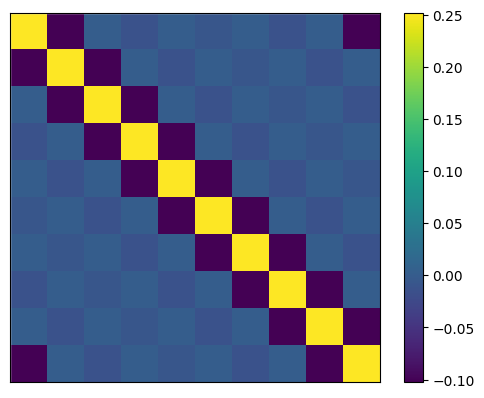

In [10]:
### Visualizing the two inverse covariance operators
plot_LinearOperator(inv_circulant_noise_cov1)
plot_LinearOperator(inv_circulant_noise_cov2)

In [11]:
### We can verify that the two inverse operators defined above are equal

np.testing.assert_allclose(
    inv_circulant_noise_cov2.to_array(),
    inv_circulant_noise_cov1.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [12]:
### We can also verify that the product of the noise covariance and the inverse noise covariance is an identity

mat_prod_circ = (circulant_noise_cov1 * inv_circulant_noise_cov1).to_array()
print(np.round(mat_prod_circ, decimals=6))

[[ 1. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0.  1. -0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0.  1. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0.  1. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0.  1. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0.  1. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0.  1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0.  1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.  1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0. -0.  1.]]


### Toeplitz noise covariance

In [13]:
### Defining covariance array and power spectrum

# Size of the covariance operator
size_toep = 15

# Size of the power spectrum for the input of Toeplitz operator must be 2N-2 or 2N-1 where N is the dimension of the Toeplitz operator
ps_size_toep = 2 * size_toep - 1

# Generate a simple 1/f spectrum
freqs_toep = np.fft.fftfreq(ps_size_toep)
power_spec_toep = np.zeros(ps_size_toep)
power_spec_toep[1:] = 1.0 / np.abs(freqs_toep[1:])
power_spec_toep[0] = 50

# Compute the self covariance from power spectrum
noise_cov_toep = np.fft.ifft(power_spec_toep).real[:size_toep]

In [14]:
### Defining Toeplitz noise covariance operator with self covariance as input
toeplitz_noise_cov1 = brahmap.NoiseCovLO_Toeplitz01(
    size=size_toep,
    input=noise_cov_toep,
    input_type="covariance",
    dtype=np.float32,
)


### Defining Toeplitz noise covariance operator with power spectrum as input
toeplitz_noise_cov2 = brahmap.NoiseCovLO_Toeplitz01(
    size=size_toep,
    input=power_spec_toep,
    input_type="power_spectrum",
    dtype=np.float32,
)

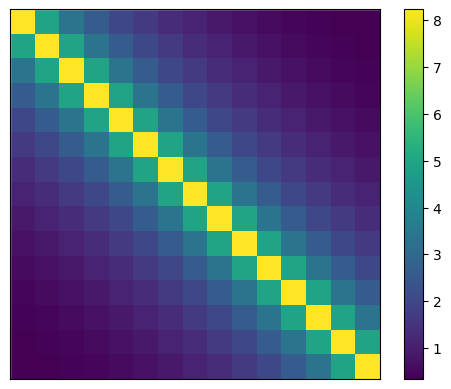

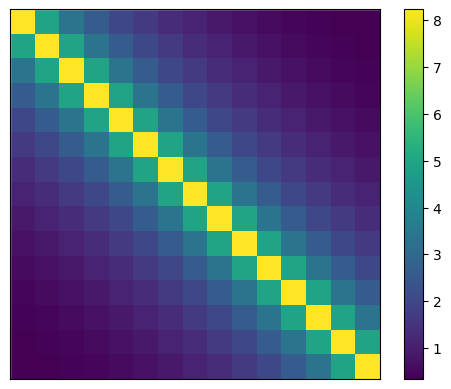

In [15]:
### Visualizing the two covariance operators
plot_LinearOperator(toeplitz_noise_cov1)
plot_LinearOperator(toeplitz_noise_cov2)

In [16]:
### We can verify that the two operators defined above are equal

np.testing.assert_allclose(
    toeplitz_noise_cov2.to_array(),
    toeplitz_noise_cov1.to_array(),
    rtol=1.0e-5,
    atol=1.0e-8,
)

In [17]:
### Defining inverse Toeplitz noise covariance operator with self covariance as input
inv_toeplitz_noise_cov1 = brahmap.InvNoiseCovLO_Toeplitz01(
    size=size_toep,
    input=noise_cov_toep,
    input_type="covariance",
    dtype=np.float32,
)


### Defining inverse Toeplitz noise covariance operator with power spectrum as input
inv_toeplitz_noise_cov2 = brahmap.InvNoiseCovLO_Toeplitz01(
    size=size_toep,
    input=power_spec_toep,
    input_type="power_spectrum",
    dtype=np.float32,
)

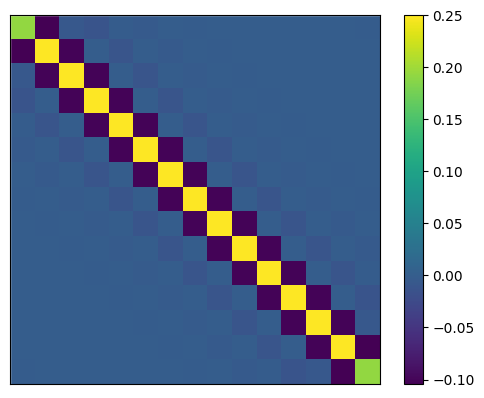

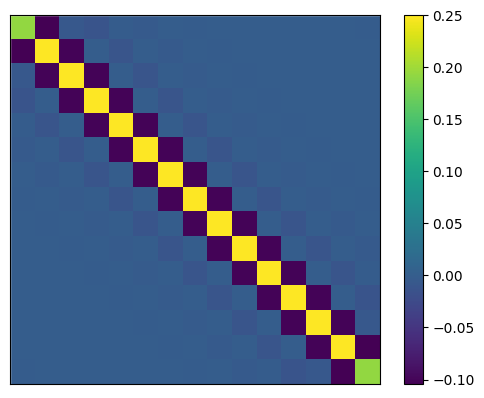

In [18]:
### Visualizing the two inverse covariance operators
plot_LinearOperator(inv_toeplitz_noise_cov1)
plot_LinearOperator(inv_toeplitz_noise_cov2)

In [19]:
### We can verify that the two inverse operators defined above are equal

np.testing.assert_allclose(
    inv_toeplitz_noise_cov2.to_array(),
    inv_toeplitz_noise_cov1.to_array(),
    rtol=1.0e-4,
    atol=1.0e-8,
)

In [20]:
### We can also verify that the product of the noise covariance and the inverse noise covariance is an identity

mat_prod_toep = (toeplitz_noise_cov1 * inv_toeplitz_noise_cov1).to_array()
print(np.round(mat_prod_toep, decimals=5))

[[ 1.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0. -0.  0.  0. -0.]
 [ 0.  1. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  0.]
 [ 0. -0.  1. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0.]
 [ 0. -0. -0.  1. -0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0.]
 [ 0.  0. -0.  0.  1. -0. -0. -0. -0.  0. -0. -0. -0.  0. -0.]
 [-0.  0. -0.  0.  0.  1. -0. -0. -0. -0. -0.  0.  0. -0.  0.]
 [ 0. -0.  0. -0. -0.  0.  1. -0. -0. -0.  0.  0.  0. -0. -0.]
 [ 0.  0. -0. -0. -0. -0. -0.  1. -0. -0. -0. -0. -0.  0.  0.]
 [-0. -0.  0.  0.  0. -0. -0. -0.  1.  0. -0. -0.  0. -0.  0.]
 [ 0. -0.  0.  0. -0. -0.  0. -0. -0.  1.  0.  0. -0.  0. -0.]
 [-0.  0. -0.  0. -0.  0. -0. -0. -0. -0.  1.  0. -0.  0.  0.]
 [-0. -0.  0. -0. -0.  0.  0.  0. -0.  0. -0.  1.  0. -0. -0.]
 [ 0. -0. -0.  0. -0. -0. -0. -0.  0.  0.  0. -0.  1. -0.  0.]
 [ 0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  0. -0. -0.  1.  0.]
 [-0.  0.  0. -0. -0.  0.  0. -0.  0. -0. -0.  0.  0.  0.  1.]]
